## Import

In [82]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

## Data preparation

In [83]:
clean_df = pd.read_csv('../data/processed/video_data_processed.csv')

In [84]:
clean_df.sample(5)

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption,hour,day,day_of_week,month,year
58293,s6i8AV-m4W8,Two Minute Papers,TU Wien Rendering #21 - Tone Mapping Basics,This lecture is held by Thomas Auzinger. In th...,Rendering|Global Illumination|ray tracing|Vien...,2015-04-30 08:21:03+00:00,5415,73,4,1328,hd,False,8,30,3,4,2015
23459,2HH1DCfbNdw,Alex Smola,Scalable Machine Learning (CS281B) - Optimizat...,Unedited Lectures from the CS281B class in UC ...,Optimization|Machine Learning,2012-02-15 21:49:08+00:00,377,1,0,3119,hd,False,21,15,2,2,2012
14482,aN6OVm0mTHo,Great Learning,How to Install Anaconda Python on Windows 10 |...,🔥1000+ Free Courses With Free Certificates: ht...,anaconda python|anaconda python 3.7|anaconda p...,2021-07-18 06:30:13+00:00,84279,958,45,579,hd,False,6,18,6,7,2021
54338,8e5vkoOblxo,TechLake,Databricks Tutorial 19 How To Create Job in Da...,#Databricks\n#Pyspark\n#Spark\n#AzureDatabrick...,databricks tutorial|how to schedule jobs in da...,2020-12-03 06:20:04+00:00,18690,198,15,516,hd,False,6,3,3,12,2020
50463,bwAGtKqkNGU,Allen Institute for AI,Kun Xu: Knowledge Based Question Answering,Kun Xu: Knowledge Based Question Answering\n\n...,(notag),2016-10-24 22:14:53+00:00,4501,34,3,2943,hd,False,22,24,0,10,2016


## Feature engineering

Create a `isTrending` column based on our criteria for the viewCount values, where labels 'low', 'medium', 'high' are assigned based on the mean value.


Noted: We assume that low: 0, medium: 1, high: 2

In [85]:
X = clean_df[['likeCount', 'commentCount', 'hour', 'day', 'month', 'year']]
mean_engagement = clean_df['viewCount'].mean()
# assign labels based on the engagement
clean_df['isTrending'] = pd.cut(clean_df['viewCount'], 
                               bins=[float('-inf'), mean_engagement, mean_engagement *10, float('inf')], 
                               labels=False)
y = clean_df['isTrending']

In [86]:
clean_df.sample(5)


,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption,hour,day,day_of_week,month,year,isTrending
4791,lw6sPHH7twk,Luke Barousse,How I use Excel as a Data Analyst,A better solution than Excel for SaaS team (Ch...,data viz by luke|business intelligence|data sc...,2022-05-16 09:00:30+00:00,439873,14257,561,698,hd,False,9,16,0,5,2022,1
34952,vH64vqnt4vM,Trouble- Free,#43 Web Security Considerations in Cryptograph...,Abroad Education Channel :\nhttps://www.youtub...,(notag),2022-01-02 08:35:41+00:00,51720,726,9,478,hd,False,8,2,6,1,2022,1
18135,jMXZT5jgudQ,DataCamp,The Data Democratization Stack (with Lilac Sch...,Lilac Schoenbeck shares what to focus on when ...,(notag),2023-11-20 12:15:03+00:00,83,1,0,285,hd,False,12,20,0,11,2023,0
35637,_XDDVqnoEVA,CampusX,Good College Vs Bad College | Choro Kaam Ki Ba...,Created by InShot:https://inshotapp.page.link/...,(notag),2022-06-27 14:00:17+00:00,2533,237,32,1189,hd,False,14,27,0,6,2022,0
19086,hPOq5HIkUWE,DataCamp,R Tutorial: Sugar content of soft drinks,Want to learn more? Take the full course at ht...,RTutorial|Vector|DataCamp|Machines,2020-03-14 10:07:51+00:00,126,0,1,257,hd,False,10,14,5,3,2020,0


In [87]:
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y ,test_size=0.3, random_state= 2023,stratify=y)
X_test, X_valid, y_test, y_valid = train_test_split(X_tmp, y_tmp ,test_size=0.3, random_state= 2023,stratify=y_tmp)

# Baseline Model Comparison


In [88]:
from sklearn.svm import LinearSVC , SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
# !pip install xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

seed = 2023
models = [
    LinearSVC(random_state=seed, dual=False, max_iter=1000),
    SVC(random_state=seed),
    RandomForestClassifier(random_state=seed),
    GradientBoostingClassifier(random_state=seed),
    ExtraTreesClassifier(),
    AdaBoostClassifier(),
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=seed)
]

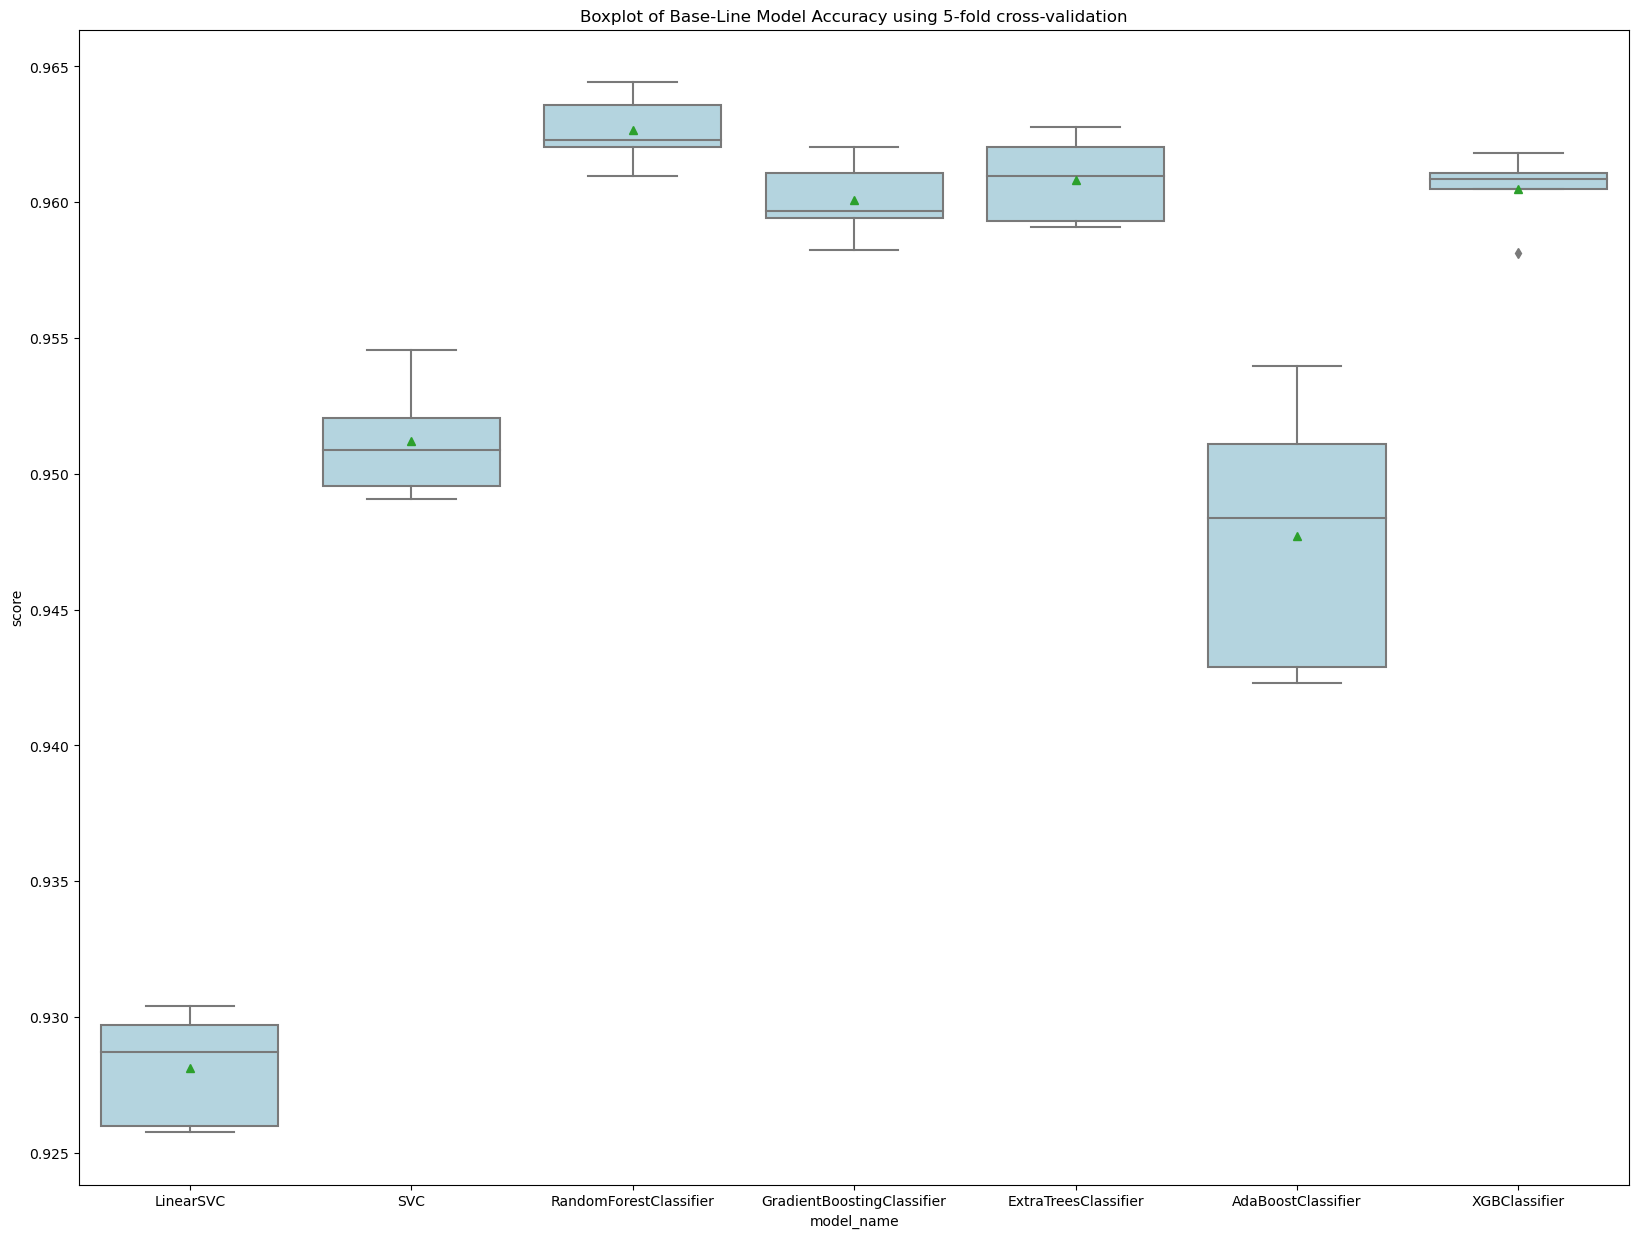

,Mean,Standard Deviation
model_name,,
RandomForestClassifier,0.962662,0.001356
ExtraTreesClassifier,0.960830,0.001630
XGBClassifier,0.960473,0.001402
GradientBoostingClassifier,0.960092,0.001491
SVC,0.951216,0.002198
AdaBoostClassifier,0.947718,0.005087
LinearSVC,0.928109,0.002127


In [89]:
def generate_baseline_result(models, X, y, metrics, cv=5, plot_result=False):
    # define k-fold
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=seed)
    entries = []
    for model in models:
        model_name = model.__class__.__name__
        scores = cross_val_score(model, X, y, scoring=metrics, cv=kfold)
        for fold_idx, score in enumerate(scores):
            entries.append((model_name, fold_idx, score))

    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'score'])
    
    mean = cv_df.groupby('model_name')['score'].mean()
    std = cv_df.groupby('model_name')['score'].std()
    
    baseline_results = pd.concat([mean,std],axis =1, ignore_index=True)
    baseline_results.columns =['Mean','Standard Deviation']
    baseline_results.sort_values(by=['Mean'], ascending = False, inplace = True)
    
    if plot_result:
        plt.figure(figsize=(20, 15))
        sns.boxplot(x ='model_name',y = 'score', data = cv_df, color ='lightblue',showmeans=True)
        plt.title('Boxplot of Base-Line Model Accuracy using 5-fold cross-validation')
        plt.show()
    
    return baseline_results

generate_baseline_result(models, X_train, y_train, metrics='accuracy',cv=5,plot_result =True )

# Fine-tune 

In [90]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(RandomForestClassifier(random_state=2023),
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_search.fit(X_valid, y_valid)

# Get the best parameters from the grid search
best_params = grid_search.best_params_

# Train the model with the best hyperparameters
best_model = RandomForestClassifier(random_state=2023, **best_params)
best_model.fit(X_train, y_train)

# Make predictions on the test set using the best model
y_pred_best = best_model.predict(X_test)

# Evaluate the best model
print(f"Best Model Accuracy: {accuracy_score(y_test, y_pred_best)}")

Best Model Accuracy: 0.9635123344173872


# Re-train on train + valid set

In [91]:
final_model_train_valid = RandomForestClassifier(random_state=2023, **best_params)

X_train_valid = pd.concat([X_train, X_valid], axis=0)
y_train_valid = pd.concat([y_train, y_valid], axis=0)
final_model_train_valid.fit(X_train_valid, y_train_valid)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=5,
                       random_state=2023)

# Test on test set 

In [92]:
y_pred_final_train_valid = final_model_train_valid.predict(X_test)
accuracy_final_train_valid = accuracy_score(y_test, y_pred_final_train_valid)
print(f"Accuracy of the Final Model on Test Set: {accuracy_final_train_valid}")

Accuracy of the Final Model on Test Set: 0.9635123344173872


# Visualize

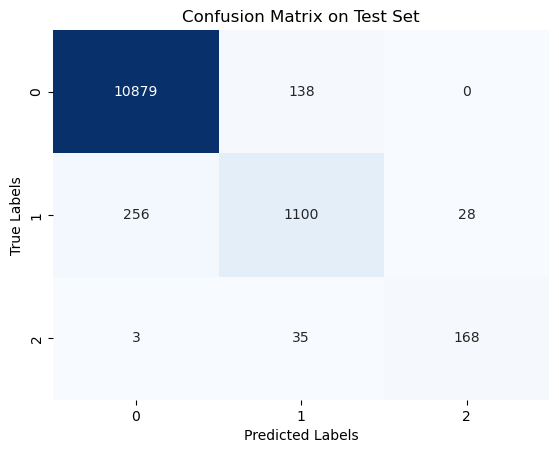

In [93]:
cm = confusion_matrix(y_test, y_pred_final_train_valid)

# Biểu đồ heatmap cho confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix on Test Set')
plt.show()

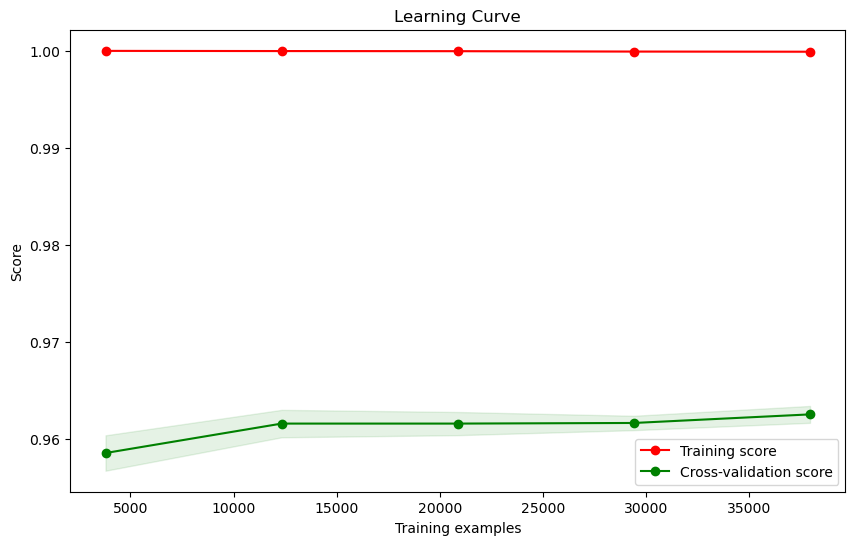

In [94]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=make_scorer(accuracy_score)
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1, color="r"
    )
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1, color="g"
    )

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Định nghĩa mô hình và các thông số cần thiết
model = RandomForestClassifier(random_state=2023, n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2023)

# Vẽ đường học tập
plot_learning_curve(model, "Learning Curve", X_train_valid, y_train_valid, cv=cv, n_jobs=-1)
plt.show()